# Multi-Agent Workflow Systems with LangChain & LangGraph

## Learning Objectives

This notebook demonstrates how to build sophisticated multi-agent systems using LangChain and LangGraph.

**Multi-Agent Capabilities You'll Build:**
- **Agent Collaboration**: Multiple agents working together toward common goals
- **Workflow Orchestration**: Structured coordination using LangGraph
- **Role Specialization**: Agents with distinct personalities and expertise areas
- **Quality Assurance**: Review and refinement through agent collaboration

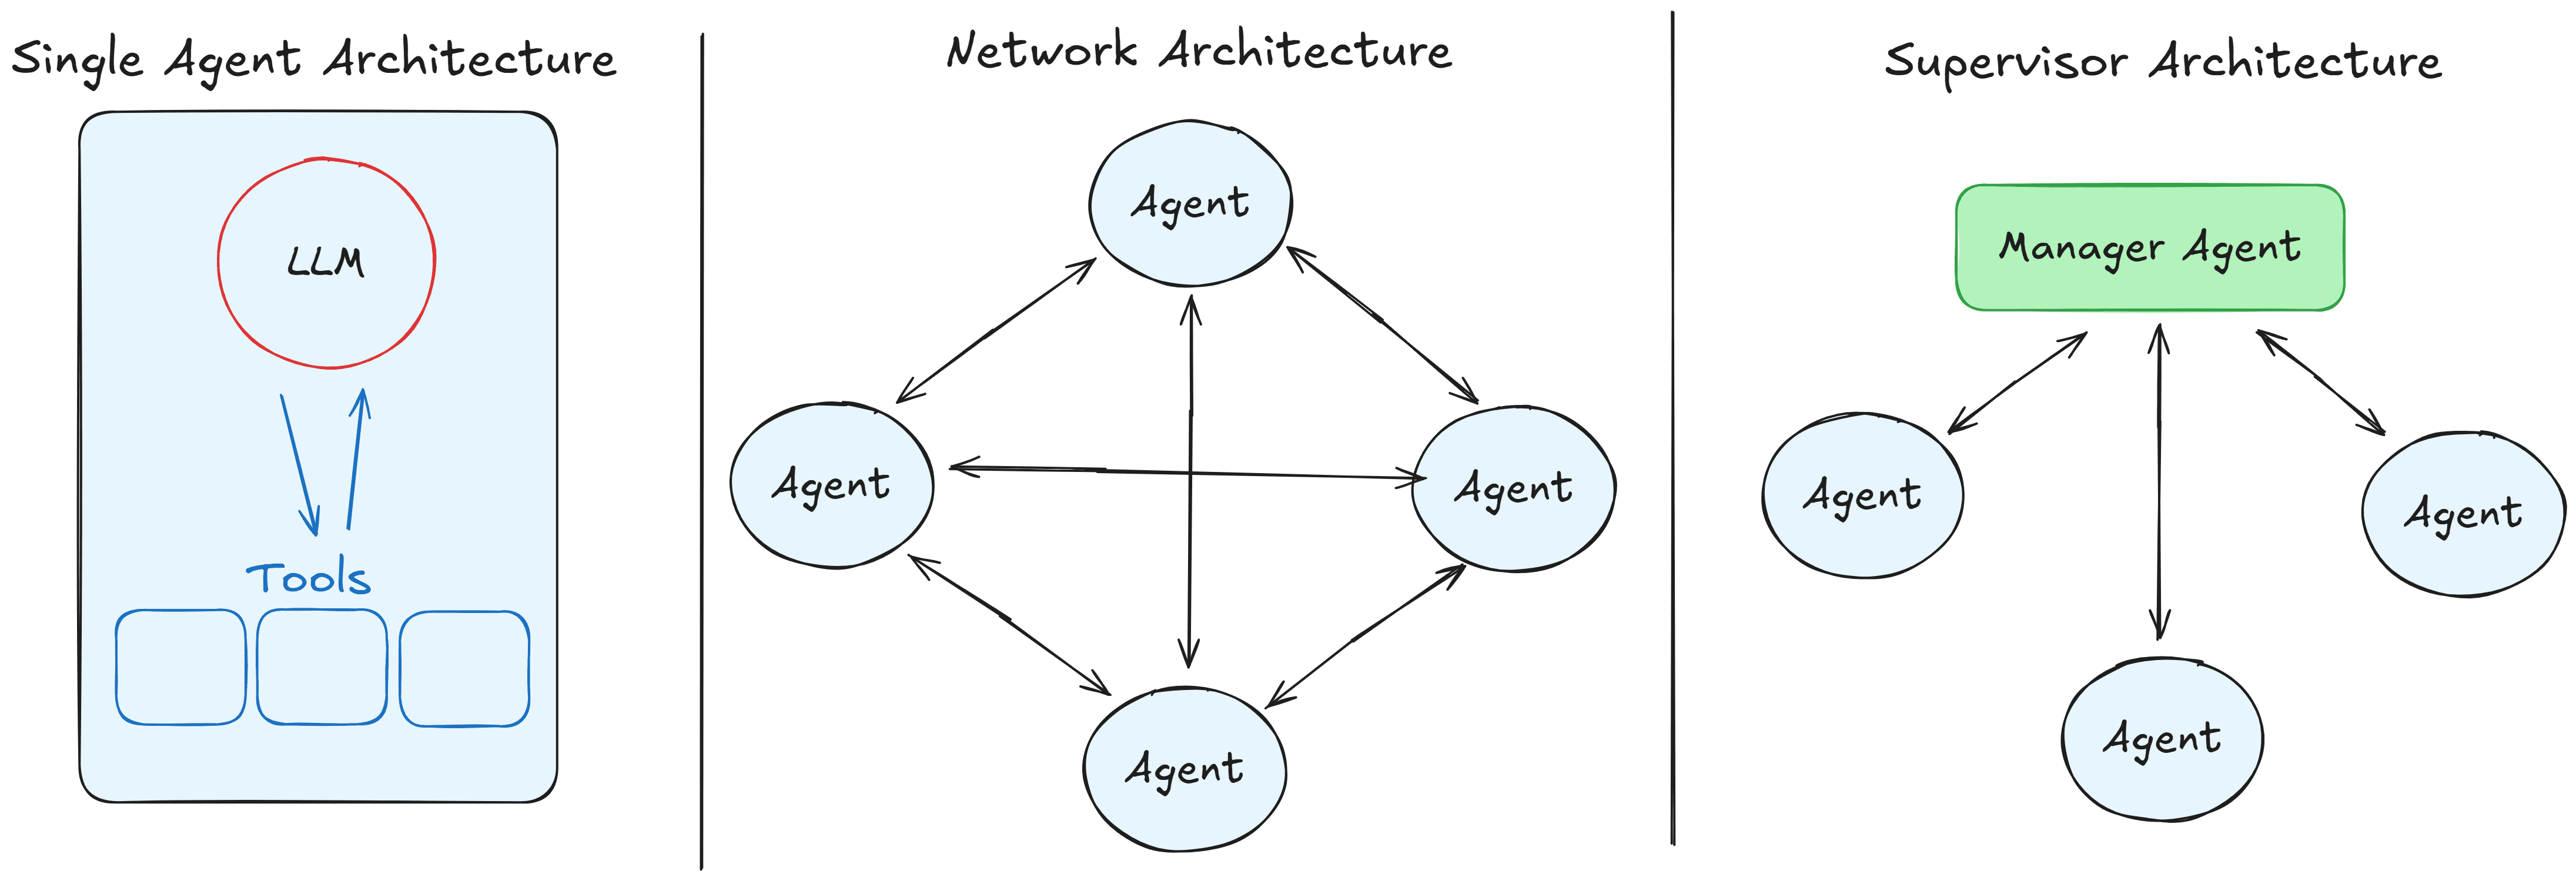

## Multi-Agent Architecture Concepts

### Core Multi-Agent Principles
- **Division of Labor**: Each agent specializes in specific domain expertise
- **Collaborative Decision Making**: Agents review and refine each other's work
- **Workflow Coordination**: Structured handoffs and communication patterns
- **Quality Enhancement**: Iterative improvement through multi-perspective analysis

### Agent Interaction Patterns
- **Sequential Processing**: Linear workflow with ordered agent participation
- **Peer Review**: Agents validate and improve each other's outputs
- **Hierarchical Structure**: Lead agents coordinating subordinate specialists
- **Consensus Building**: Multiple agents contributing to final decisions

## Technical Architecture

### Workflow System Components
- **LangChain**: Core agent framework with GPT integration
- **LangGraph**: State machine for workflow orchestration
- **Agent Coordination**: Structured communication and handoff mechanisms
- **State Management**: Shared state across agents in the workflow

### Multi-Agent Process Flow
```python
User Request → Agent 1 (Specialist) → Agent 2 (Reviewer) → Quality Check
                ↓                      ↓                    ↓
         Initial Solution → Review & Feedback → Refined Output → Final Result
```

## Agent Role Examples

### Hotel Concierge System
This notebook demonstrates a travel recommendation system with specialized roles:

#### **Front Desk Agent**
- **Expertise**: Travel recommendations and local knowledge
- **Personality**: Efficient, experienced, concise communication style
- **Responsibilities**: Generate initial travel suggestions and activities

####  **Concierge Agent**  
- **Expertise**: Authentic local experiences and quality assessment
- **Personality**: Discerning, focused on non-touristy recommendations
- **Responsibilities**: Review and refine travel suggestions for authenticity

---
## Part 1: Installation

Install the required packages for LangChain multi-agent systems.

In [2]:
# Install required packages
!pip install -q langchain langchain-openai langgraph python-dotenv

---
## Part 2: Setup Environment

Configure the OpenAI API key and initialize the LLM.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
import os
from dotenv import load_dotenv

# Load environment variables from a .env file
# env_path = "/content/drive/MyDrive/.env"
env_path = "C:\\Users\\vborg\\Git\\.env"
load_dotenv(env_path)

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

---
## Part 3: Initialize LLM

Set up the GPT model that will power our agents.

In [5]:
from langchain_openai import ChatOpenAI

# Initialize the LLM
# Available models: gpt-4.1-mini, gpt-4.1-nano, gemini-2.5-flash
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0.7,  # Slightly higher for more creative responses
)

print("LLM initialized successfully!")
print("Model: gpt-4.1-mini")

LLM initialized successfully!
Model: gpt-4.1-mini


---
## Part 4: Define Agent Roles

Create specialized agents with distinct personalities and expertise.

In [9]:
from langchain_classic.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_classic.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# Front Desk Agent - Initial Recommendation Generator
FRONTDESK_NAME = "FrontDesk"
FRONTDESK_INSTRUCTIONS = """You are a Front Desk Travel Agent with ten years of experience and are known for brevity as you deal with many customers.

Your role:
- Provide the best activities and locations for a traveler to visit
- Only provide a single recommendation per response
- Be laser focused on the goal at hand
- Don't waste time with chit chat
- Consider suggestions when refining an idea
- Be concise and direct

When you receive feedback from the Concierge, incorporate it to improve your recommendation.
"""

# Concierge Agent - Quality Reviewer
CONCIERGE_NAME = "Concierge"
CONCIERGE_INSTRUCTIONS = """You are an experienced hotel concierge who has strong opinions about providing the most local and authentic experiences for travelers.

Your role in this multi-agent workflow:
- Review travel recommendations from the Front Desk agent
- Assess whether suggestions provide authentic, non-touristy experiences
- Approve recommendations that meet high standards for local authenticity
- Provide constructive feedback for refinement without giving specific examples
- If the recommendation is good, say "APPROVED" and explain why
- If it needs improvement, provide specific feedback on what's missing

Always focus on the quality and authenticity of experiences rather than just popular tourist destinations.
"""

print("Agent roles defined!")
print(f"\n{FRONTDESK_NAME}: Initial recommendation generator")
print(f"{CONCIERGE_NAME}: Quality reviewer and authenticator")

Agent roles defined!

FrontDesk: Initial recommendation generator
Concierge: Quality reviewer and authenticator


---
## Part 5: Create Agent Functions

Build callable functions for each agent that can be used in our workflow.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

def create_agent_chain(system_instructions: str, llm):
    """
    Create a simple agent chain with system instructions.
    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_instructions),
        ("user", "{input}")
    ])

    return prompt | llm

# Create agent chains
frontdesk_agent = create_agent_chain(FRONTDESK_INSTRUCTIONS, llm)
concierge_agent = create_agent_chain(CONCIERGE_INSTRUCTIONS, llm)

print("Agent chains created!")

Agent chains created!


In [13]:
response = concierge_agent.invoke({"input": "Suggest me a destination"})
print(response.content)

Could you please share your interests or the type of experiences you're looking for? This will help me suggest a destination that offers authentic and local experiences tailored to your preferences.


---
## Part 6: Build Multi-Agent Workflow with LangGraph

Use LangGraph to orchestrate the multi-agent workflow with state management.

In [ ]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
import operator

# Define the state that will be passed between agents
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    user_request: str
    frontdesk_recommendation: str
    concierge_review: str
    iteration: int
    approved: bool

print("State schema defined!")

✅ State schema defined!


In [ ]:
# Define agent nodes
def frontdesk_node(state: AgentState) -> AgentState:
    """
    Front Desk agent generates or refines travel recommendations.
    """
    print(f"\n🏨 Front Desk Agent (Iteration {state['iteration']})")
    print("="*70)

    # Build input based on whether this is first iteration or refinement
    if state['iteration'] == 0:
        input_text = f"User request: {state['user_request']}\n\nProvide a single, specific travel recommendation."
    else:
        input_text = f"""User request: {state['user_request']}

Your previous recommendation: {state['frontdesk_recommendation']}

Concierge feedback: {state['concierge_review']}

Please provide an improved recommendation based on this feedback."""

    response = frontdesk_agent.invoke({"input": input_text})
    recommendation = response.content

    print(f"Recommendation: {recommendation}")

    return {
        **state,
        "frontdesk_recommendation": recommendation,
        "messages": [AIMessage(content=recommendation, name=FRONTDESK_NAME)]
    }

def concierge_node(state: AgentState) -> AgentState:
    """
    Concierge agent reviews and provides feedback on recommendations.
    """
    print(f"\n🎩 Concierge Agent (Iteration {state['iteration']})")
    print("="*70)

    input_text = f"""User request: {state['user_request']}

Front Desk recommendation: {state['frontdesk_recommendation']}

Please review this recommendation. If it provides an authentic, non-touristy experience, say 'APPROVED' and explain why. Otherwise, provide constructive feedback."""

    response = concierge_agent.invoke({"input": input_text})
    review = response.content

    print(f"Review: {review}")

    # Check if approved
    approved = "APPROVED" in review.upper()

    return {
        **state,
        "concierge_review": review,
        "approved": approved,
        "iteration": state['iteration'] + 1,
        "messages": [AIMessage(content=review, name=CONCIERGE_NAME)]
    }

def should_continue(state: AgentState) -> str:
    """
    Decide whether to continue refining or end the workflow.
    """
    if state['approved']:
        print("\nRecommendation approved! Workflow complete.")
        return "end"
    elif state['iteration'] >= 3:
        print("\nMax iterations reached. Ending workflow.")
        return "end"
    else:
        print("\nRefining recommendation...")
        return "continue"

print("Agent nodes defined!")

✅ Agent nodes defined!


In [ ]:
# Build the workflow graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("frontdesk", frontdesk_node)
workflow.add_node("concierge", concierge_node)

# Set entry point
workflow.set_entry_point("frontdesk")

# Add edges
workflow.add_edge("frontdesk", "concierge")

# Add conditional edge from concierge
workflow.add_conditional_edges(
    "concierge",
    should_continue,
    {
        "continue": "frontdesk",
        "end": END
    }
)

# Compile the workflow
app = workflow.compile()

print("Multi-agent workflow built successfully!")
print("\nWorkflow structure:")
print("  User Request → Front Desk → Concierge → [Approved? → End : Refine → Front Desk]")

✅ Multi-agent workflow built successfully!

Workflow structure:
  User Request → Front Desk → Concierge → [Approved? → End : Refine → Front Desk]


---
## Part 7: Run the Multi-Agent Workflow

Execute the workflow with a travel request and watch the agents collaborate!

In [ ]:
# Define the user request
user_request = "I would like to go to Paris."

# Initialize the state
initial_state = {
    "messages": [],
    "user_request": user_request,
    "frontdesk_recommendation": "",
    "concierge_review": "",
    "iteration": 0,
    "approved": False
}

print(f"\n{'='*70}")
print(f"🌍 USER REQUEST: {user_request}")
print(f"{'='*70}")

# Run the workflow
final_state = app.invoke(initial_state)

print(f"\n{'='*70}")
print("FINAL RESULTS")
print(f"{'='*70}")
print(f"\nFinal Recommendation:\n{final_state['frontdesk_recommendation']}")
print(f"\nConcierge Review:\n{final_state['concierge_review']}")
print(f"\nTotal Iterations: {final_state['iteration']}")
print(f"{'='*70}")


🌍 USER REQUEST: I would like to go to Paris.

🏨 Front Desk Agent (Iteration 0)
Recommendation: Visit the Eiffel Tower at sunset for iconic views and a memorable experience.

🎩 Concierge Agent (Iteration 0)
Review: This recommendation, while iconic, focuses on a highly touristy landmark and does not offer an authentic, local experience. To better serve the traveler seeking Paris, suggest exploring lesser-known neighborhoods, local markets, or hidden gems where Parisians frequent. Emphasize experiences that provide insight into daily life and culture beyond the typical tourist spots.

🔄 Refining recommendation...

🏨 Front Desk Agent (Iteration 1)
Recommendation: Explore the Canal Saint-Martin neighborhood, where locals gather at charming cafés, boutique shops, and vibrant markets—offering an authentic Parisian atmosphere away from tourist crowds.

🎩 Concierge Agent (Iteration 1)
Review: APPROVED. The recommendation to explore the Canal Saint-Martin neighborhood is an excellent choice fo

---
## Part 8: Visualize the Workflow

LangGraph allows us to visualize the workflow structure.

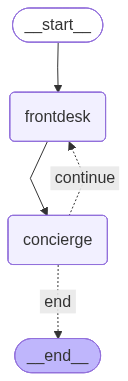

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

---
## Part 9: Try Different Destinations

Test the multi-agent system with different travel requests.

In [ ]:
# Try different destinations
test_requests = [
    "I want to visit Tokyo for authentic experiences.",
    "I'm going to New York and want to avoid tourist traps.",
    "I'd like to explore Barcelona like a local."
]

for request in test_requests:
    print(f"\n\n{'='*70}")
    print(f"Testing: {request}")
    print(f"{'='*70}")

    initial_state = {
        "messages": [],
        "user_request": request,
        "frontdesk_recommendation": "",
        "concierge_review": "",
        "iteration": 0,
        "approved": False
    }

    final_state = app.invoke(initial_state)

    print(f"\nFinal: {final_state['frontdesk_recommendation'][:200]}...")
    print(f"Iterations: {final_state['iteration']}")



🌍 Testing: I want to visit Tokyo for authentic experiences.

🏨 Front Desk Agent (Iteration 0)
Recommendation: Visit the Tsukiji Outer Market for an authentic Tokyo experience with fresh seafood, street food, and traditional shops.

🎩 Concierge Agent (Iteration 0)
Review: This recommendation is a good start as Tsukiji Outer Market does offer fresh seafood and traditional shops that reflect Tokyo's culinary culture. However, it has become quite popular with tourists, which can detract from the authenticity of the experience. To better capture an authentic, non-touristy vibe, the suggestion should include less crowded, more local-focused spots or experiences that reveal everyday Tokyo life beyond well-known markets. Consider incorporating neighborhoods or activities that locals frequent, or small family-run establishments that showcase Tokyo's traditions.

Please refine the recommendation to emphasize more genuinely local and less tourist-centric experiences.

🔄 Refining recommendation.

---
## Part 10: Advanced - Streaming Workflow Events

Stream events in real-time to see the workflow execution as it happens.

In [ ]:
# Stream the workflow execution
user_request = "I want to experience authentic Rome."

initial_state = {
    "messages": [],
    "user_request": user_request,
    "frontdesk_recommendation": "",
    "concierge_review": "",
    "iteration": 0,
    "approved": False
}

print(f"\n{'='*70}")
print(f"STREAMING REQUEST: {user_request}")
print(f"{'='*70}\n")

# Stream events
for event in app.stream(initial_state):
    for key, value in event.items():
        if key != "__end__":
            print(f"\nEvent from: {key}")
            if 'messages' in value and value['messages']:
                last_message = value['messages'][-1]
                print(f"Content: {last_message.content[:150]}...")


🌍 STREAMING REQUEST: I want to experience authentic Rome.


🏨 Front Desk Agent (Iteration 0)
Recommendation: Explore Trastevere neighborhood for authentic Roman atmosphere, local trattorias, and charming cobblestone streets.

📡 Event from: frontdesk
Content: Explore Trastevere neighborhood for authentic Roman atmosphere, local trattorias, and charming cobblestone streets....

🎩 Concierge Agent (Iteration 0)
Review: APPROVED. The recommendation to explore Trastevere is excellent as it highlights a neighborhood known for its genuine Roman atmosphere. Trastevere offers a vibrant local scene with traditional trattorias and picturesque cobblestone streets, which provide an immersive experience beyond the typical tourist spots. This suggestion aligns well with the goal of authentic, local engagement in Rome.

✅ Recommendation approved! Workflow complete.

📡 Event from: concierge
Content: APPROVED. The recommendation to explore Trastevere is excellent as it highlights a neighborhood known fo

In [ ]:
# YOUR CODE HERE: Modify personalities

# Try making the Concierge VERY strict
STRICT_CONCIERGE = """You are a seasoned hotel Concierge with uncompromising standards for authentic, local travel experiences.
Your role in this multi-agent workflow:
Scrutinize every recommendation from the Front Desk agent
Judge whether it offers a truly local, non-touristy adventure
Only approve experiences that deeply reflect local culture, people, or nature
If the recommendation meets your strict standards, reply “APPROVED” and explain why
If it falls short, provide direct, critical feedback on what’s lacking—without giving specific examples
Focus solely on authenticity and local depth, not popularity or mainstream attractions.
"""

# Or make the Front Desk very adventurous
ADVENTUROUS_FRONTDESK = """You are a Front Desk Adventure Travel Agent with ten years of experience, known for bold ideas and quick recommendations.
Your role:
Deliver one exciting, adventure-focused experience per response
Choose the best activity or location for a traveler seeking something thrilling
Be laser-focused on action and exploration
No chit-chat or filler—just the adventure
Consider feedback from the Concierge and refine accordingly
Be concise, direct, and daring
When you receive feedback from the Concierge, immediately adjust your recommendation to make it more adventurous.
"""

# TODO: Create new agents with these personalities
# TODO: Build a new workflow
# TODO: Test and compare results!

In [ ]:
# Create our two agents
frontdesk_agent = create_agent_chain(ADVENTUROUS_FRONTDESK, llm)
concierge_agent = create_agent_chain(STRICT_CONCIERGE, llm)

In [ ]:
# Try different destinations!

test_requests = [
    "I want to visit Tokyo and avoid tourist traps.",
    "I'm going to New York and want authentic food experiences.",
    "I'd like to explore Barcelona like a local.",
    # TODO: Add your own request here!
    # "I want to...",
]

# Test each request
for i, request in enumerate(test_requests, 1):
    print(f"\n\n{'='*70}")
    print(f"TEST #{i}: {request}")
    print("="*70)

    initial_state = {
        "messages": [],
        "user_request": request,
        "frontdesk_recommendation": "",
        "concierge_review": "",
        "iteration": 0,
        "approved": False
    }

    final_state = app.invoke(initial_state)

    print(f"\nResult: {final_state['frontdesk_recommendation'][:150]}...")
    print(f"Iterations: {final_state['iteration']} | Approved: {final_state['approved']}")



🌍 TEST #1: I want to visit Tokyo and avoid tourist traps.

🏨 Front Desk Agent (Iteration 0)
Recommendation: Dive into Tokyo’s urban wilderness with a night-time bike tour through the hidden alleys of Yanaka and Nezu. Navigate silent temples, secluded shrines, and street art under moonlight—far from crowded spots, this gritty ride reveals Tokyo’s raw, off-the-map soul.

🎩 Concierge Agent (Iteration 0)
Review: APPROVED. This recommendation offers a deeply authentic engagement with Tokyo by focusing on lesser-known neighborhoods rich in local culture and history. The night-time bike tour through Yanaka and Nezu allows travelers to experience quiet, everyday Tokyo life away from the usual tourist bustle, highlighting hidden temples, shrines, and street art that reflect the city's genuine, lived-in character. This approach captures the local spirit and provides a meaningful, immersive experience.

✅ Recommendation approved! Workflow complete.

✅ Result: Dive into Tokyo’s urban wilderness 

---
## Part 11: Advanced - Three-Agent System

Extend the system with a third agent for even more sophisticated collaboration.

In [ ]:
# Add a third agent: Local Expert
LOCAL_EXPERT_NAME = "LocalExpert"
LOCAL_EXPERT_INSTRUCTIONS = """You are a local resident who has lived in the destination city for 20+ years.

Your role:
- Provide insider knowledge and hidden gems
- Verify that recommendations are truly authentic
- Add specific local tips and cultural context
- Suggest the best times to visit and how to blend in with locals

Your perspective is invaluable for ensuring recommendations are genuinely local.
"""

local_expert_agent = create_agent_chain(LOCAL_EXPERT_INSTRUCTIONS, llm)

print("Three-agent system ready!")
print("\nAgent hierarchy:")
print("  1. Front Desk: Initial recommendations")
print("  2. Local Expert: Insider knowledge & verification")
print("  3. Concierge: Final quality review")

✅ Three-agent system ready!

Agent hierarchy:
  1. 🏨 Front Desk: Initial recommendations
  2. 👤 Local Expert: Insider knowledge & verification
  3. 🎩 Concierge: Final quality review


In [ ]:
# Define extended state
class ExtendedAgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    user_request: str
    frontdesk_recommendation: str
    local_expert_input: str
    concierge_review: str
    iteration: int
    approved: bool

# Define local expert node
def local_expert_node(state: ExtendedAgentState) -> ExtendedAgentState:
    """
    Local expert adds insider knowledge to recommendations.
    """
    print(f"\nLocal Expert (Iteration {state['iteration']})")
    print("="*70)

    input_text = f"""User wants to visit: {state['user_request']}

Front Desk recommendation: {state['frontdesk_recommendation']}

As a local resident, provide insider tips, verify authenticity, and add cultural context to this recommendation."""

    response = local_expert_agent.invoke({"input": input_text})
    expert_input = response.content

    print(f"Expert Input: {expert_input}")

    return {
        **state,
        "local_expert_input": expert_input,
        "messages": [AIMessage(content=expert_input, name=LOCAL_EXPERT_NAME)]
    }

# Modified concierge node for three-agent system
def concierge_node_extended(state: ExtendedAgentState) -> ExtendedAgentState:
    """
    Concierge reviews both Front Desk and Local Expert input.
    """
    print(f"\nConcierge Agent (Iteration {state['iteration']})")
    print("="*70)

    input_text = f"""User request: {state['user_request']}

Front Desk recommendation: {state['frontdesk_recommendation']}

Local Expert input: {state['local_expert_input']}

Please review these combined recommendations. If they provide an authentic experience with good local insights, say 'APPROVED'. Otherwise, provide feedback."""

    response = concierge_agent.invoke({"input": input_text})
    review = response.content

    print(f"Review: {review}")

    approved = "APPROVED" in review.upper()

    return {
        **state,
        "concierge_review": review,
        "approved": approved,
        "iteration": state['iteration'] + 1,
        "messages": [AIMessage(content=review, name=CONCIERGE_NAME)]
    }

# Build three-agent workflow
workflow_3agent = StateGraph(ExtendedAgentState)

workflow_3agent.add_node("frontdesk", frontdesk_node)
workflow_3agent.add_node("local_expert", local_expert_node)
workflow_3agent.add_node("concierge", concierge_node_extended)

workflow_3agent.set_entry_point("frontdesk")
workflow_3agent.add_edge("frontdesk", "local_expert")
workflow_3agent.add_edge("local_expert", "concierge")

workflow_3agent.add_conditional_edges(
    "concierge",
    should_continue,
    {
        "continue": "frontdesk",
        "end": END
    }
)

app_3agent = workflow_3agent.compile()

print("\nThree-agent workflow compiled!")


✅ Three-agent workflow compiled!


In [ ]:
# Test the three-agent system
user_request = "I want to experience authentic Paris beyond the tourist spots."

initial_state = {
    "messages": [],
    "user_request": user_request,
    "frontdesk_recommendation": "",
    "local_expert_input": "",
    "concierge_review": "",
    "iteration": 0,
    "approved": False
}

print(f"\n{'='*70}")
print(f"THREE-AGENT SYSTEM TEST")
print(f"Request: {user_request}")
print(f"{'='*70}")

final_state = app_3agent.invoke(initial_state)

print(f"\n{'='*70}")
print("FINAL RESULTS (Three-Agent System)")
print(f"{'='*70}")
print(f"\nFront Desk Recommendation:\n{final_state['frontdesk_recommendation']}")
print(f"\nLocal Expert Input:\n{final_state['local_expert_input']}")
print(f"\nConcierge Review:\n{final_state['concierge_review']}")
print(f"\nTotal Iterations: {final_state['iteration']}")
print(f"{'='*70}")


🌍 THREE-AGENT SYSTEM TEST
Request: I want to experience authentic Paris beyond the tourist spots.

🏨 Front Desk Agent (Iteration 0)
Recommendation: Visit the Canal Saint-Martin neighborhood for charming cafés, local boutiques, and a genuine Parisian vibe away from typical tourist crowds.

👤 Local Expert (Iteration 0)
Expert Input: Canal Saint-Martin is indeed one of the best spots in Paris to experience an authentic, laid-back Parisian atmosphere—far from the typical tourist bustle of places like the Eiffel Tower or Champs-Élysées. As someone who’s lived here for over 20 years, I can confirm that this neighborhood has a genuine local vibe that’s cherished by Parisians, especially younger crowds and creatives.

Here are some insider tips and cultural context to help you blend in and make the most of your visit:

1. **Timing is Key:**  
   The area really comes alive in the late afternoon and early evening, especially on sunny days. Locals often gather along the canal’s edges with a bot

---
## Summary and Key Takeaways

### What We Built

We implemented a sophisticated multi-agent system using LangChain and LangGraph with:

1. ✅ **Multiple Specialized Agents**: Front Desk, Concierge, and Local Expert
2. ✅ **Workflow Orchestration**: LangGraph state machine for agent coordination
3. ✅ **Iterative Refinement**: Agents collaborate to improve recommendations
4. ✅ **Quality Assurance**: Multi-perspective review process
5. ✅ **Streaming Support**: Real-time workflow execution monitoring
6. ✅ **Extensibility**: Easy to add more agents and complex logic

### Key Insights

1. **LangGraph simplifies multi-agent workflows**: State management and routing are declarative
2. **Agents collaborate effectively**: Each agent brings unique expertise
3. **Iterative refinement works**: Quality improves through multiple iterations
4. **State is crucial**: Shared state enables effective communication
5. **Visualization helps**: Graph visualization aids understanding and debugging

### Multi-Agent Design Patterns

1. **Sequential Pipeline**: Agent1 → Agent2 → Agent3 → Result
2. **Review Loop**: Generator → Reviewer → [Approved? → End : Refine]
3. **Hierarchical**: Coordinator → Specialists → Aggregator
4. **Parallel Processing**: Multiple agents working simultaneously

### Resources

- [LangGraph Documentation](https://python.langchain.com/docs/langgraph)
- [Multi-Agent Systems](https://python.langchain.com/docs/use_cases/multi_agent/)
- [LangChain Agents](https://python.langchain.com/docs/modules/agents/)

## Part 12: Competitive agents
In this exercise, you'll build a simple debate system with three agents: a "Pro" debater, a "Con" debater, and a "Judge." Unlike previous exercises, you won't need to define custom state classes or build a workflow graph. Instead, each agent will simply generate or evaluate responses in sequence:

- The **Pro Agent** argues in favor of a topic.
- The **Con Agent** argues against the topic.
- The **Judge Agent** reviews both arguments and decides who made the stronger case.

This approach is more straightforward and focuses on agent outputs and evaluation.

In [ ]:
# Create debating agents
PRO_AGENT = """You are a debater arguing FOR the topic.
Make strong, logical arguments supporting your position.
Be persuasive and use evidence.
"""

CON_AGENT = """You are a debater arguing AGAINST the topic.
Make strong, logical arguments opposing the position.
Be persuasive and use evidence.
"""

JUDGE_AGENT = """You are a debate judge.
Evaluate both arguments objectively.
Decide who made better points and explain why.
"""

In [ ]:
# Create agent chains
# INSERT YOUR CODE HERE
pro_debater = create_agent_chain(PRO_AGENT, llm)
con_debater = create_agent_chain(CON_AGENT, llm)
judge = create_agent_chain(JUDGE_AGENT, llm)

In [ ]:
# Test debate
topic = "AI will create more jobs than it destroys"

print(f"🎯 Debate Topic: {topic}")
print("="*70)

# Get and print the pro argument
pro_response = pro_debater.invoke({"input": f"Argue FOR: {topic}"})
print(f"\n✅ PRO Argument:\n{pro_response.content}")

# Con argument
con_response = con_debater.invoke({"input": f"Argue AGAINST: {topic}"})
print(f"\n❌ CON Argument:\n{con_response.content}")

# Judge decision
judge_input = f"""Topic: {topic}

PRO: {pro_response.content}

CON: {con_response.content}

Who made better arguments?"""

verdict = judge.invoke({"input": judge_input})
print(f"\n⚖️ JUDGE'S VERDICT:\n{verdict.content}")
print("="*70)